<a href="https://colab.research.google.com/github/iam-vsr/demo/blob/main/JG_ML_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading the Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
train_file_path = '/content/drive/My Drive/AI_ML/train.tsv'
test_file_path = '/content/drive/My Drive/AI_ML/test.tsv'


In [4]:
import pandas as pd

train_df = pd.read_csv(train_file_path, sep='\t')
test_df = pd.read_csv(test_file_path, sep='\t')


# **EDA**

**About the Data**

In [5]:
train_df.head()

,Unnamed: 0,title,text,subject,date,label
0,2619,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politicsNews,"July 22, 2017",1
1,16043,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,"Jun 19, 2017",0
2,876,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politicsNews,"November 2, 2017",1
3,19963,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left-news,"Sep 17, 2016",0
4,10783,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,"May 26, 2017",0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  30000 non-null  int64 
 1   title       30000 non-null  object
 2   text        30000 non-null  object
 3   subject     30000 non-null  object
 4   date        30000 non-null  object
 5   label       30000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.4+ MB


In [7]:
train_df.describe()

,Unnamed: 0,label
count,30000.000000,30000.000000
mean,11207.925800,0.484067
std,6533.101217,0.499754
min,0.000000,0.000000
25%,5560.750000,0.000000
50%,11071.500000,0.000000
75%,16832.500000,1.000000
max,23479.000000,1.000000


In [8]:
train_df['Unnamed: 0']

,Unnamed: 0
0,2619
1,16043
2,876
3,19963
4,10783
...,...
29995,6880
29996,17818
29997,5689
29998,15805


In [9]:
train_df['label'].value_counts()

,count
label,
0,15478
1,14522


#**Data Cleaning and Feature Engineering**

In [10]:
#let's make a class:

import pandas as pd
import re
import string
from dateutil import parser
from textblob import TextBlob

class DataCleaner:
    def __init__(self, keywords=["shocking", "breaking", "exclusive", "amazing", "incredible"]):
        self.keywords = keywords

    def clean_text(self, text):
        text = re.sub(r"http\S+", "", text)
        text = re.sub(f"[{string.punctuation}]", "", text)
        text = re.sub(r"\s+", " ", text)
        return text.strip().lower()

    def parse_date(self, date):
        try:
            return parser.parse(date)
        except Exception:
            return None

    def keyword_density(self, text):
        return sum(1 for word in text.split() if word in self.keywords) / len(text.split())

    def clean_and_feature(self, df):
        # 1. Drop Unnamed Column
        df = df.drop(columns=["Unnamed: 0"], errors='ignore')  # errors='ignore' to avoid errors if the column doesn't exist

        # 2. Clean Text Columns
        df['clean_title'] = df['title'].apply(self.clean_text)
        df['clean_text'] = df['text'].apply(self.clean_text)

        # 3. Parse and Clean Dates
        df['date_new'] = df['date'].apply(self.parse_date)
        df = df.dropna(subset=['date_new'])  # Drop rows with invalid dates
        df['date'] = df['date_new']
        df = df.drop(columns=['date_new'])

        # 4. Remove Rows with Empty/Short Text
        df = df[df['clean_text'].str.strip() != ""]
        df = df[df['clean_text'].str.split().str.len() >= 5]

        # 5. Feature Engineering
        df['title_word_count'] = df['clean_title'].apply(lambda x: len(x.split()))
        df['title_sentiment'] = df['clean_title'].apply(lambda x: TextBlob(x).sentiment.polarity)
        df['text_word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
        df['keyword_density'] = df['clean_text'].apply(self.keyword_density)
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day_of_week'] = df['date'].dt.dayofweek

        # One-hot encoding for 'subject'
        df = pd.get_dummies(df, columns=['subject'], drop_first=True)

        return df

In [11]:
cleaner = DataCleaner()
cleaned_train_df = cleaner.clean_and_feature(train_df)
cleaned_test_df = cleaner.clean_and_feature(test_df)


In [12]:
cleaned_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29902 entries, 0 to 29999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   title                 29902 non-null  object        
 1   text                  29902 non-null  object        
 2   date                  29902 non-null  datetime64[ns]
 3   label                 29902 non-null  int64         
 4   clean_title           29902 non-null  object        
 5   clean_text            29902 non-null  object        
 6   title_word_count      29902 non-null  int64         
 7   title_sentiment       29902 non-null  float64       
 8   text_word_count       29902 non-null  int64         
 9   keyword_density       29902 non-null  float64       
 10  year                  29902 non-null  int32         
 11  month                 29902 non-null  int32         
 12  day_of_week           29902 non-null  int32         
 13  subject_Middle-east  

In [13]:
cleaned_train_df.head()

,title,text,date,label,clean_title,clean_text,title_word_count,title_sentiment,text_word_count,keyword_density,year,month,day_of_week,subject_Middle-east,subject_News,subject_US_News,subject_left-news,subject_politics,subject_politicsNews,subject_worldnews
0,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,2017-07-22,1,excia head says trump remarks on russia interf...,former cia director john brennan on friday cri...,9,0.0,432,0.0,2017,7,5,False,False,False,False,False,True,False
1,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,2017-06-19,0,you won’t believe his punishment hispanic stor...,how did this man come to own this store there ...,19,0.5,434,0.0,2017,6,0,False,False,False,False,False,False,False
2,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,2017-11-02,1,federal reserve governor powells policy views ...,president donald trump on thursday tapped fede...,10,0.6,631,0.0,2017,11,3,False,False,False,False,False,True,False
3,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,2016-09-17,0,scoundrel hillary supporter starts “trumpleaks...,hillary clinton ally david brock is offering t...,7,0.0,195,0.0,2016,9,5,False,False,False,True,False,False,False
4,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,2017-05-26,0,nancy pelosi arrogantly dismisses questions on...,pleading ignorance is a perfect ploy for nancy...,13,0.0,169,0.0,2017,5,4,False,False,False,False,True,False,False


In [14]:
cleaned_train_df['label'].value_counts()

,count
label,
0,15381
1,14521


In [15]:
cleaned_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8241 entries, 0 to 8266
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   title                 8241 non-null   object        
 1   text                  8241 non-null   object        
 2   date                  8241 non-null   datetime64[ns]
 3   label                 8241 non-null   int64         
 4   clean_title           8241 non-null   object        
 5   clean_text            8241 non-null   object        
 6   title_word_count      8241 non-null   int64         
 7   title_sentiment       8241 non-null   float64       
 8   text_word_count       8241 non-null   int64         
 9   keyword_density       8241 non-null   float64       
 10  year                  8241 non-null   int32         
 11  month                 8241 non-null   int32         
 12  day_of_week           8241 non-null   int32         
 13  subject_Middle-east   8

In [16]:
cleaned_test_df.head()

,title,text,date,label,clean_title,clean_text,title_word_count,title_sentiment,text_word_count,keyword_density,year,month,day_of_week,subject_Middle-east,subject_News,subject_US_News,subject_left-news,subject_politics,subject_politicsNews,subject_worldnews
0,Conservatives Will HATE What Donald Trump Just...,Donald Trump isn t exactly a stranger to makin...,2016-02-14,0,conservatives will hate what donald trump just...,donald trump isn t exactly a stranger to makin...,12,-0.800000,359,0.0,2016,2,6,False,True,False,False,False,False,False
1,Trump victory may create new tension between U...,Donald Trump’s U.S. election victory may creat...,2016-11-09,1,trump victory may create new tension between u...,donald trump’s us election victory may create ...,13,0.136364,100,0.0,2016,11,2,False,False,False,False,False,True,False
2,WATCH: Hundreds of ILLEGAL ALIENS Storm Senate...,A couple of quick questions come to mind when ...,2017-11-09,0,watch hundreds of illegal aliens storm senate ...,a couple of quick questions come to mind when ...,14,-0.500000,381,0.0,2017,11,3,False,False,False,False,True,False,False
3,"Democratic Senator Franken to resign: CNN, cit...",U.S. Democratic Senator Al Franken will announ...,2017-12-07,1,democratic senator franken to resign cnn citin...,us democratic senator al franken will announce...,8,0.000000,43,0.0,2017,12,3,False,False,False,False,False,True,False
4,GANG OF DOMESTIC TERRORISTS Violently Attack L...,***WARNING*** Violence is graphic***This Trump...,2017-01-21,0,gang of domestic terrorists violently attack l...,warning violence is graphicthis trump supporte...,20,-0.133333,48,0.0,2017,1,5,False,False,False,True,False,False,False


# **Splitting Data**

In [19]:
from sklearn.model_selection import train_test_split

X = cleaned_train_df.drop(['label', 'title', 'text', 'date'], axis=1)
y = cleaned_train_df['label']
# Create a train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Check sizes
print(f"Training set size: {X_train.shape[0]} rows")
print(f"Validation set size: {X_val.shape[0]} rows")


Training set size: 23921 rows
Validation set size: 5981 rows


# **Vectorization**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [20]:
# Define numeric columns to scale
numeric_columns = ['title_word_count', 'text_word_count', 'keyword_density', 'year', 'month', 'day_of_week']

# Initialize vectorizers for text
text_vectorizer = TfidfVectorizer(max_features=10000)
title_vectorizer = TfidfVectorizer(max_features=5000)

# Vectorize text features
X_train_text = text_vectorizer.fit_transform(X_train['clean_text'])
X_train_title = title_vectorizer.fit_transform(X_train['clean_title'])

X_val_text = text_vectorizer.transform(X_val['clean_text'])
X_val_title = title_vectorizer.transform(X_val['clean_title'])

# Scale numeric features
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[numeric_columns])
X_val_numeric = scaler.transform(X_val[numeric_columns])

# Combine vectorized and numeric features
import scipy.sparse

X_train_combined = scipy.sparse.hstack([
    X_train_text,
    X_train_title,
    scipy.sparse.csr_matrix(X_train_numeric)
])

X_val_combined = scipy.sparse.hstack([
    X_val_text,
    X_val_title,
    scipy.sparse.csr_matrix(X_val_numeric)
])


In [21]:
X_train_combined.shape, X_val_combined.shape

((23921, 15006), (5981, 15006))

In [ ]:
# Ensure the test data has the same numeric columns
numeric_test = cleaned_test_df[numeric_columns]

# Scale numeric features using the fitted scaler
numeric_test_scaled = scaler.transform(numeric_test)

# Vectorize text columns using the fitted vectorizers
test_text_vectorized = text_vectorizer.transform(cleaned_test_df['clean_text'])
test_title_vectorized = title_vectorizer.transform(cleaned_test_df['clean_title'])

# Combine text and numeric features
test_combined = scipy.sparse.hstack([
    test_text_vectorized,
    test_title_vectorized,
    scipy.sparse.csr_matrix(numeric_test_scaled)
])


In [ ]:
test_combined.shape

# **Training**

**Training on Logistic Regression**

In [22]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
model.fit(X_train_combined, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [23]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_val_combined)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy}")
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.9879618792844006
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3046
           1       0.98      0.99      0.99      2935

    accuracy                           0.99      5981
   macro avg       0.99      0.99      0.99      5981
weighted avg       0.99      0.99      0.99      5981



Woah, such high accuracy, SUS!!!

**Let's check for data leakage and features' importance**

In [24]:
# Checking for overlap between training and validation sets
train_indices = set(X_train.index)
val_indices = set(X_val.index)
overlap = train_indices.intersection(val_indices)

print(f"Number of overlapping rows between train and validation sets: {len(overlap)}")


Number of overlapping rows between train and validation sets: 0


In [26]:
# Get feature names from vectorizers
text_features = text_vectorizer.get_feature_names_out()
title_features = title_vectorizer.get_feature_names_out()

# Combine feature names with appropriate prefixes for clarity
combined_features = [f"text_{feature}" for feature in text_features] + [f"title_{feature}" for feature in title_features]


In [27]:
# Extract coefficients from the model
coefficients = model.coef_[0]  # Logistic Regression stores coefficients in a 2D array; select the first row


In [28]:
# Pair feature names with their coefficients
feature_importance = sorted(zip(combined_features, coefficients), key=lambda x: abs(x[1]), reverse=True)

# Display the top 10 most important features
print("Top 10 important features:")
for feature, coef in feature_importance[:10]:
    print(f"{feature}: {coef:.4f}")


Top 10 important features:
text_said: 14.1814
title_video: -7.4261
text_on: 5.6900
title_says: 5.6836
title_breaking: -4.9349
text_is: -4.5242
text_this: -4.3168
text_via: -4.0442
text_us: 3.9684
text_reuters: 3.9361


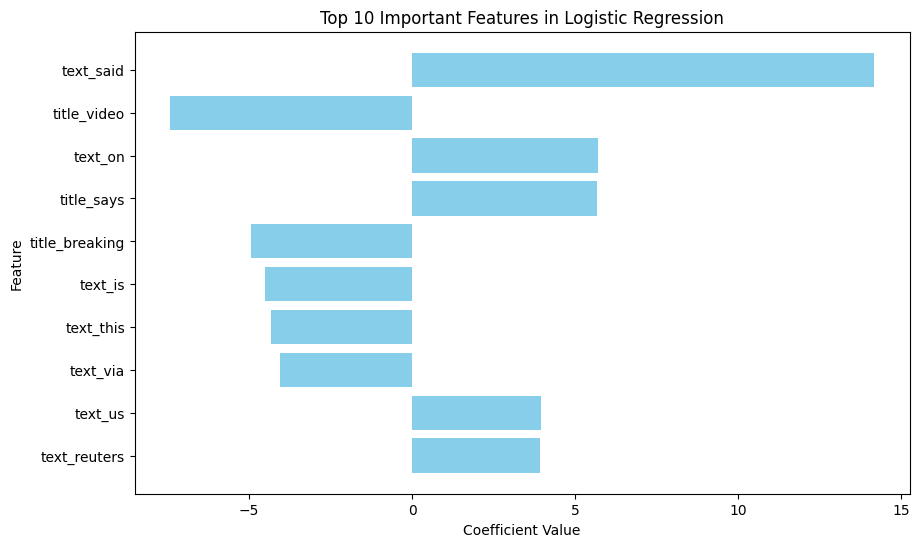

In [29]:
import matplotlib.pyplot as plt

# Select top 10 features
top_features = feature_importance[:10]
features, coefs = zip(*top_features)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features, coefs, color='skyblue')
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Top 10 Important Features in Logistic Regression")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


Features doesn't seem to be affecting our results

# **Making Predictions**

In [32]:
# Make predictions on the test data
test_predictions = model.predict(test_combined)
test_probabilities = model.predict_proba(test_combined)[:, 1]  # Probability for the positive class (1)


In [33]:
from sklearn.metrics import classification_report, roc_auc_score

# Assume the test labels are stored in `test_data['label']`
test_labels = cleaned_test_df['label']

# Evaluate performance
print("Test Set Classification Report:")
print(classification_report(test_labels, test_predictions))

# Calculate AUC-ROC
test_auc_roc = roc_auc_score(test_labels, test_probabilities)
print(f"Test Set AUC-ROC: {test_auc_roc:.4f}")


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4258
           1       0.99      0.99      0.99      3983

    accuracy                           0.99      8241
   macro avg       0.99      0.99      0.99      8241
weighted avg       0.99      0.99      0.99      8241

Test Set AUC-ROC: 0.9993


In [39]:
import random

# Select a random subset of indices
num_samples = 5  # Number of examples to display
random_indices = random.sample(range(len(cleaned_test_df)), num_samples)

# Display the selected examples with true labels and predictions
for idx in random_indices:
    print(f"Title: {cleaned_test_df.iloc[idx]['title']}")
    print(f"True Label: {cleaned_test_df.iloc[idx]['label']}")
    print(f"Predicted Label: {test_predictions[idx]}")
    print(f"Prediction Probability: {test_probabilities[idx]:.4f}")
    print("-" * 50)


Title: Trump says he respects CIA in his first visit to headquarters
True Label: 1
Predicted Label: 1
Prediction Probability: 0.8230
--------------------------------------------------
Title: Even Trump’s Best Friend Joe Scarborough Can’t Handle His ‘Disqualifying’ KKK Support (VIDEO)
True Label: 0
Predicted Label: 0
Prediction Probability: 0.0010
--------------------------------------------------
Title: Rohingya grieve after baby dies in border crossing
True Label: 1
Predicted Label: 1
Prediction Probability: 0.9742
--------------------------------------------------
Title: MAN BRUTALLY ASSAULTED At CA Trump Rally Tells Horrific Story Of Attack By Domestic Terrorists [VIDEO]
True Label: 0
Predicted Label: 0
Prediction Probability: 0.0007
--------------------------------------------------
Title: CNN’S ANDERSON “POOPER” Responds After Outcry Over ‘Crude’ Swipe At Trump Supporter [Video]
True Label: 0
Predicted Label: 0
Prediction Probability: 0.0306
---------------------------------------